In [37]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from scipy.stats import spearmanr, pearsonr

cproj = cartopy.crs.PlateCarree()
xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7]

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
gridlines = [i+1 for i in range(366) if (days[i].day) == 1]
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

# **Background information**

## **Physical geography**

In [35]:
elev = xr.open_dataset("data/gebco_2023_n10.0_s6.0_w-85.0_e-75.0.nc").elevation
sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))

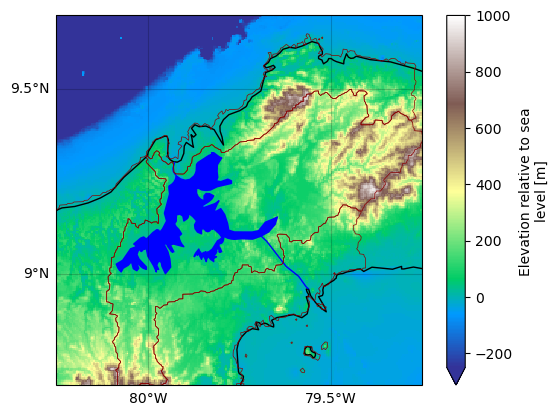

In [36]:
elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(cmap = "terrain", vmax = 1000, vmin = -250, subplot_kws = {"projection" : cproj, "extent" : (xn, xx, yn, yx)})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, color = "blue")
ax.add_feature(cartopy.feature.RIVERS, color = "blue")
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)  # shapefile doesn't give much more detail than the box

plt.savefig("fig/elevation.png")

## **Lake level data**
https://evtms-rpts.pancanal.com/eng/h2o/index.html (https://pancanal.com/en/)

- the three driest years observed were 1997, 2015 and 2023 (in order of accumulated precip deficit by September)  
- in all three of these years, the lake levels were roughly the same at the start of the year (about 87.5ft) -
the 2023 level has dropped much more quickly than in either 1997 or 2015.  
&nbsp;
- Jun-Sep 2023 is the longest that levels have remained this low.
&nbsp;
- previously, the lowest levels have occurred in April-June of the years following the lowest precipitation, then recovered quickly.  
This suggests that next year, levels might be even lower.


In [39]:
df = pd.read_csv("data/Download_Gatun_Lake_Water_Level_History.csv", parse_dates = ["DATE_LOG"], index_col = 0)
df = df.rename(columns = {"GATUN_LAKE_LEVEL(FEET)" : "level"})

In [40]:
df.loc[df.level == 0, "level"] = np.nan # remove zeros

In [28]:
df[np.abs(df - df.rolling(15).mean()) > 1] = np.nan # remove any readings that are more than 1ft from the smoothed line (seems implausible)

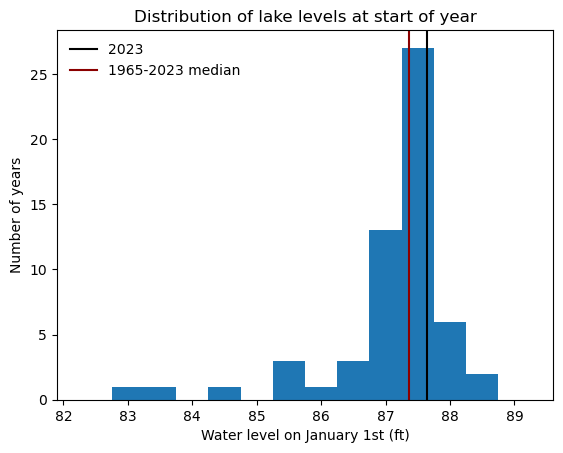

In [80]:
# lake level at start of each year - 2023 not particularly unusual - in fact, above the median level
df.loc[df.index.day_of_year == 1].hist(grid = False, bins = np.arange(82.25, 89.75,0.5))

# df.loc[df.index.day_of_year == 1].loc[slice("1990","2020")].hist(ax = plt.gca(), grid = False, bins = np.arange(82.25, 89.75,0.5), alpha = 0.3, color = "darkblue")

plt.gca().axvline(df.loc["2023-01-01", "level"], color = "k", label = "2023")
plt.gca().axvline(df.loc[df.index.day_of_year == 1, "level"].median(), color = "darkred", label = "1965-2023 median")

plt.legend(edgecolor = "w")

plt.xlabel("Water level on January 1st (ft)")
plt.ylabel("Number of years")
plt.title("Distribution of lake levels at start of year")
plt.savefig("fig/starting-level-histogram.png")

In [30]:
df_proj = pd.read_csv("data/Gatun_Water_Level_Projection.csv", skiprows = 3, header = None, names = ["proj_date", "level", "surcharge", "maxd_1", "maxd_2"],
           index_col = 0, parse_dates = [0]).sort_values("proj_date")[["level"]]

In [31]:
df_clim = df.loc[slice("1990", "2020")].groupby(df.loc[slice("1990", "2020")].index.day_of_year).mean()

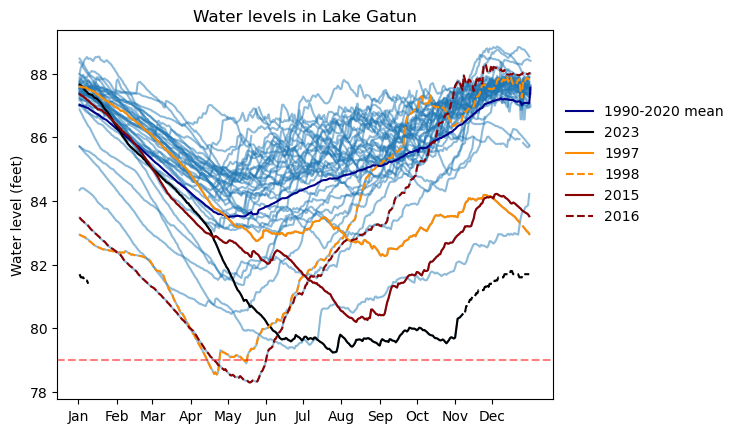

In [32]:
df_clim.plot(color = "darkblue", legend = False)
ax = plt.gca()
   
ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False)

ts_y = df.loc[str(1997)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkorange", legend = False)

ts_y = df.loc[str(1998)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkorange", legend = False, ls = "--")

ts_y = df.loc[str(2015)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkred", legend = False)

ts_y = df.loc[str(2016)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkred", legend = False, ls = "--")

for y in range(1981, 2024):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "tab:blue", alpha = 0.5, legend = False, label = "_", zorder = -99)
    

for y in range(2023, 2025):
    ts_y = df_proj.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "k", ls = "--", legend = False)

sc_xlabels(dates = df.loc["2020"].to_xarray().DATE_LOG)
plt.gcf().legend(["1990-2020 mean", "2023", "1997","1998","2015","2016"], bbox_to_anchor = (0.9,0.6), loc = "center left", edgecolor = "w")
ax.set_xlabel("")
ax.set_ylabel("Water level (feet)")
ax.set_title("Water levels in Lake Gatun")

ax.axhline(79, color = "red", alpha = 0.5, ls = "--")

plt.savefig("fig/water-levels.png")

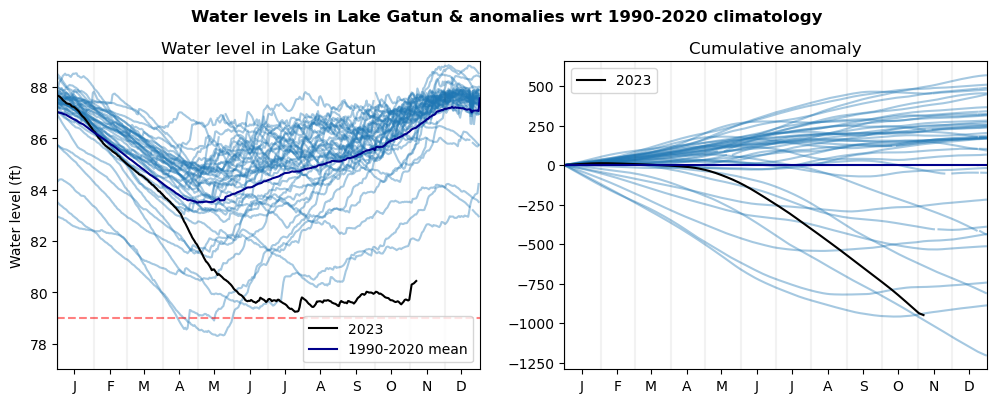

In [34]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]

for y in range(1981, 2023):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ax.plot(ts_y.index, ts_y, color = "tab:blue", alpha = 0.4)

ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ax.plot(ts_y.index, df.loc[str(2023)], color = "k", label = "2023")    

ax.plot(df_clim.index, df_clim, color = "darkblue", label = "1990-2020 mean")    
ax.set_ylim(77,89)
ax.axhline(79, color = "red", alpha = 0.5, ls = "--")
ax.legend()
ax.set_ylabel("Water level (ft)")
ax.set_title("Water level in Lake Gatun")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): 
    zz = pd.merge(ts, df_clim, left_on = ts.index.day_of_year, right_index  = True)
    zz["diff"] = zz.level_x - zz.level_y
    return zz[["diff"]].cumsum()

ax = axs[1]

for y in range(1981, 2023):
    ts_y = ts_fun(df.loc[str(y)])
    ax.plot(ts_y.index.day_of_year, ts_y, color = "tab:blue", alpha = 0.4)

ts_y = ts_fun(df.loc[str(2023)])
ax.plot(ts_y.index.day_of_year, ts_y, color = "k", alpha = 1, label = "2023")

plt.axhline(0, color = "darkblue")
ax.set_title("Cumulative anomaly")
ax.legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
    
plt.suptitle("Water levels in Lake Gatun & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/water-levels-with-anomaly.png")

---
# **Gridded data**

## **CHIRPS**

In [115]:
chirps = xr.open_dataset("data/chirps05_panama.nc").precip.sel(longitude = slice(xn,xx), latitude = slice(yn, yx))
chirps_ts = chirps.mean(["latitude", "longitude"])
chirps_ts.to_netcdf("data/chirps_panama_ts.nc")

chirps_ts.resample(time = "MS").mean().to_dataframe().to_csv("data/chirps_monthly.csv")

## **MSWEP/MSWX**

In [118]:
mswep = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx))
mswep = mswep.where(regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(mswep.lon, mswep.lat).squeeze(drop = True))
mswep_ts = mswep.mean(["lat", "lon"])
mswep_ts.to_netcdf("data/mswep_panama_ts.nc")

mswep_ts.resample(time = "MS").mean().to_dataframe().to_csv("data/mswep_monthly.csv")

In [8]:
vnm = "tmin"
mswx = xr.open_dataset("data/mswx_"+vnm+"_panama.nc")[vnm].sel(lon = slice(xn,xx), lat = slice(yn, yx))
mswx = mswx.where(regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(mswx.lon, mswx.lat).squeeze(drop = True))
mswx_ts = mswx.mean(["lat", "lon"])
mswx_ts.to_netcdf("data/mswx-"+vnm+"_panama_ts.nc")

mswx_ts.resample(time = "MS").mean().to_dataframe().to_csv("data/mswx-"+vnm+"_monthly.csv")

# **Precipitation anomalies**

In [82]:
chirps_ts = xr.open_dataset("data/chirps_panama_ts.nc").precip
chirps_clim_9020 = chirps_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

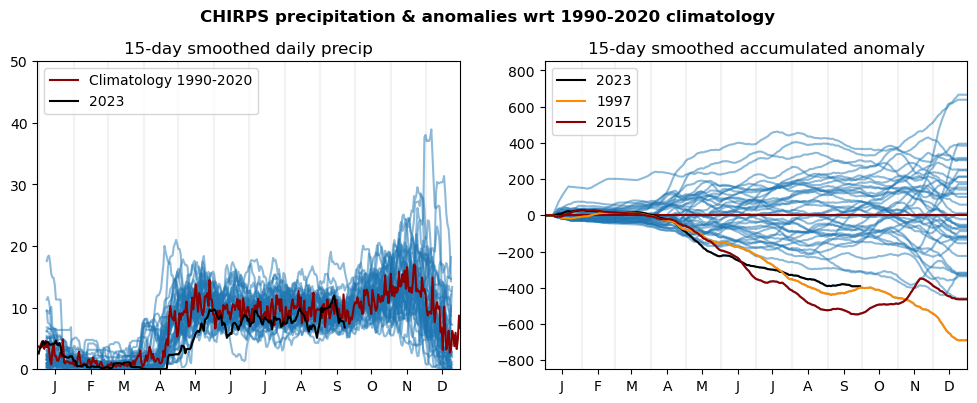

In [155]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(chirps_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred", label = "Climatology 1990-2020")
# ax.plot(clim_1020.dayofyear, clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(chirps_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")
ax.set_title("15-day smoothed daily precip")
sc_xlabels(dates = chirps_ts.sel(time = "2000").time, ax = ax)

ax.legend(loc = "upper left")
ax.set_ylim(0,50)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - chirps_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(chirps_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkred")
# ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred")
# ax.plot(chirps_clim_1020.dayofyear, chirps_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(chirps_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(chirps_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(chirps_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend()
ax.set_title("15-day smoothed accumulated anomaly")
sc_xlabels(dates = chirps_ts.sel(time = "2000").time, ax = ax)
ax.set_ylim(-850,850)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
    
plt.suptitle("CHIRPS precipitation & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/chirps_anomaly-wrt-1990-2020.png")

- 2023 has been a dry year - however, not the driest on record - both 1997 and 2015 had a larger precipitation deficit by the end of August.  
- 2023 differs in that May and June were very dry; the last few months have been below average, but not catastrophically dry

## **Anomalies over this region**

In [81]:
mswep_ts = xr.open_dataset("data/mswep_panama_ts.nc").pr
mswep_clim_9020 = mswep_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

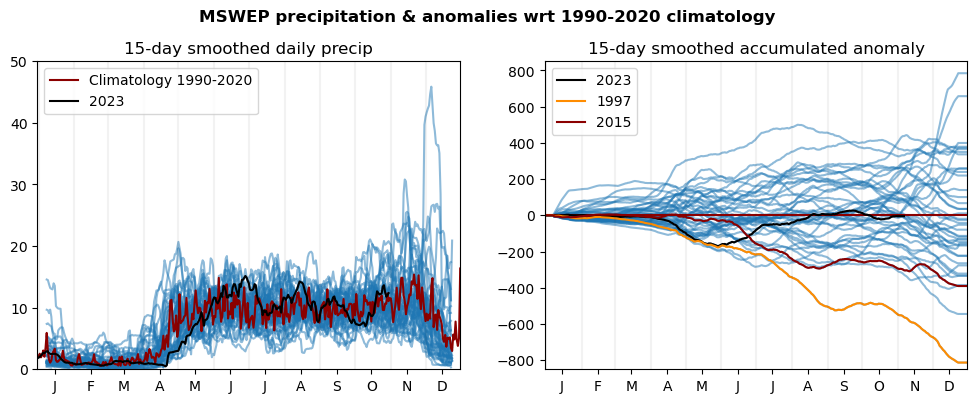

In [164]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(mswep_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(mswep_clim_9020.dayofyear, mswep_clim_9020, color = "darkred", label = "Climatology 1990-2020")
# ax.plot(mswep_clim_1020.dayofyear, mswep_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(mswep_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")
ax.set_title("15-day smoothed daily precip")
sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)

ax.legend(loc = "upper left")
ax.set_ylim(0,50)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - mswep_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(mswep_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkred")
# ax.plot(mswep_clim_9020.dayofyear, mswep_clim_9020, color = "darkred")
# ax.plot(mswep_clim_1020.dayofyear, mswep_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(mswep_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(mswep_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(mswep_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend()
ax.set_title("15-day smoothed accumulated anomaly")
sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)
ax.set_ylim(-850,850)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
    
plt.suptitle("MSWEP precipitation & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/mswep_anomaly-wrt-1990-2020.png")

## **Compare CHIRPS & MSWEP**

In [99]:
era5l_ts = convert_units_to(xr.open_dataset("tmp.nc").tp.mean(["latitude", "longitude"]), "mm")

In [102]:
xr.open_dataset("tmp.nc")

<xarray.Dataset>
Dimensions:    (longitude: 11, latitude: 11, time: 315)
Coordinates:
  * longitude  (longitude) float32 -80.25 -80.15 -80.05 ... -79.45 -79.35 -79.25
  * latitude   (latitude) float32 9.7 9.6 9.5 9.4 9.3 9.2 9.1 9.0 8.9 8.8 8.7
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-11
Data variables:
    tp         (time, latitude, longitude) float32 ...

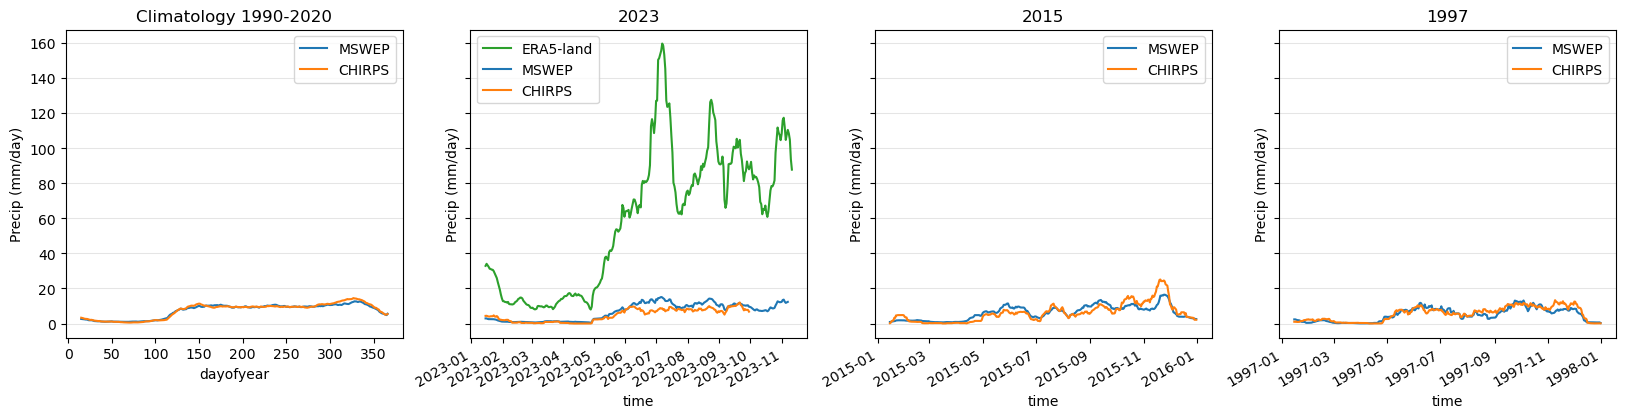

In [108]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,4), dpi = 100, sharey = True)

era5l_dat = era5l_ts.rolling(time = 15).mean()
era5l_dat = era5l_dat.rename(time = "dayofyear")
era5l_dat.plot(ax = axs[1], label = "ERA5-land", color = "tab:green")

for i in range(4):
    mswep_dat = ([mswep_clim_9020] + [mswep_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]
    chirps_dat = ([chirps_clim_9020] + [chirps_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]

    mswep_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "MSWEP")
    chirps_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "CHIRPS")
    axs[i].set_ylabel("Precip (mm/day)")
    
    axs[i].grid(color = "k", alpha = 0.1, axis = "y")
    axs[i].legend()

axs[0].set_title("Climatology 1990-2020")
axs[1].set_title("2023")
axs[2].set_title("2015")
axs[3].set_title("1997")

plt.savefig("fig/mswep-chirps-precipitation.png")

In [92]:
# smoothed climatology
chirps_clim_9020 = chirps_ts.rolling(time = 15).mean().sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()
mswep_clim_9020 = mswep_ts.rolling(time = 15).mean().sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

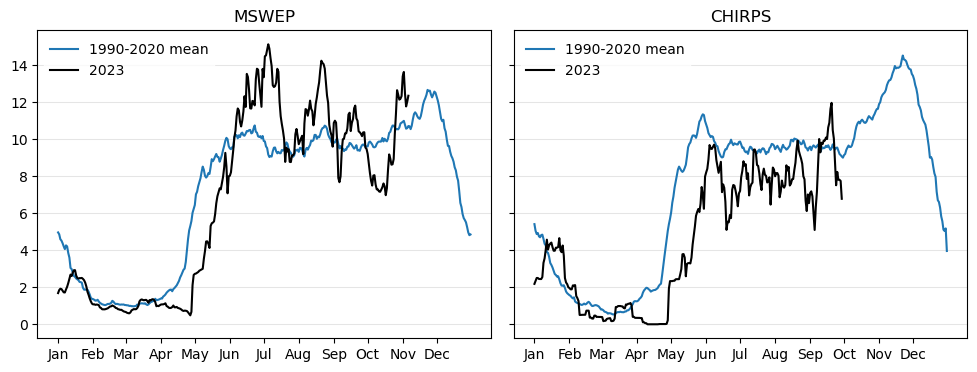

In [93]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True)
plt.subplots_adjust(wspace = 0.05)

for i in range(2):
    
    ax = axs[i]
    ts_clim = [mswep_clim_9020, chirps_clim_9020][i]
    ts_2023 = [mswep_ts, chirps_ts][i].rolling(time = 15).mean().loc["2023"].rename(time = "dayofyear")
    
    axs[i].grid(color = "k", alpha = 0.1, axis = "y")
    ax.plot(ts_clim, label = "1990-2020 mean")
    ax.plot(ts_2023, color = "k", label = "2023")
    
    ax.legend(edgecolor = "w")
    ax.set_title(["MSWEP", "CHIRPS"][i])
    
    sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)
    
axs[0].set_label("Precipitation (mm/day)")
plt.savefig("fig/precip-vs-climatology.png")

In [94]:
    mswep_dat = ([mswep_clim_9020] + [mswep_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]
    chirps_dat = ([chirps_clim_9020] + [chirps_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]

    mswep_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "MSWEP")
    chirps_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "CHIRPS")
    axs[i].legend()
    axs[i].set_ylabel("Precip (mm/day)")
    
    axs[i].grid(color = "k", alpha = 0.1, axis = "y")
    
axs[0].set_title("Climatology 1990-2020")
axs[1].set_title("2023")
axs[2].set_title("2015")
axs[3].set_title("1997")

plt.savefig("fig/mswep-chirps-vs-climatology.png")

IndexError: index 2 is out of bounds for axis 0 with size 2

## **SPI**
Fitting done in R because Python parameter estimates are unstable

In [40]:
mswep_spi = pd.read_csv("data/mswep_spi-monthly.csv", index_col = "time", parse_dates = ["time"])
chirps_spi = pd.read_csv("data/chirps_spi-monthly.csv", index_col = "time", parse_dates = ["time"])

In [171]:
nino34rel = decode_times(xr.open_dataset("../../Data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).dropna("time", "any").to_dataframe()
nino34rel["nino1"] = nino34rel["Nino3.4r"].rolling(1, center = False).mean() 
nino34rel["nino3"] = nino34rel["Nino3.4r"].rolling(3, center = False).mean() 
nino34rel["nino6"] = nino34rel["Nino3.4r"].rolling(6, center = False).mean() 
nino34rel["nino12"] = nino34rel["Nino3.4r"].rolling(12, center = False).mean() 
nino34rel["nino24"] = nino34rel["Nino3.4r"].rolling(24, center = False).mean() 

In [177]:
mswep_spi.loc["2023"]

,spi_1,spi_3,spi_6,spi_12,spi_24
time,,,,,
2023-01-01,0.293794,-0.660131,-0.437657,0.614556,0.440775
2023-02-01,-0.297933,-0.764295,-0.689730,0.578218,0.428130
2023-03-01,0.107387,0.042208,-0.762355,0.430977,0.377605
2023-04-01,-1.736862,-1.344710,-1.028721,-0.078733,0.129415
2023-05-01,-1.539459,-2.284445,-1.928897,-0.506757,-0.005936
2023-06-01,0.922667,-1.030849,-0.845854,-0.474393,-0.015123
2023-07-01,1.207727,0.523857,-0.161885,-0.503437,-0.012774
2023-08-01,0.373376,1.355523,0.017597,-0.584167,-0.095303
2023-09-01,0.533284,1.310555,0.171116,-0.570744,-0.040051


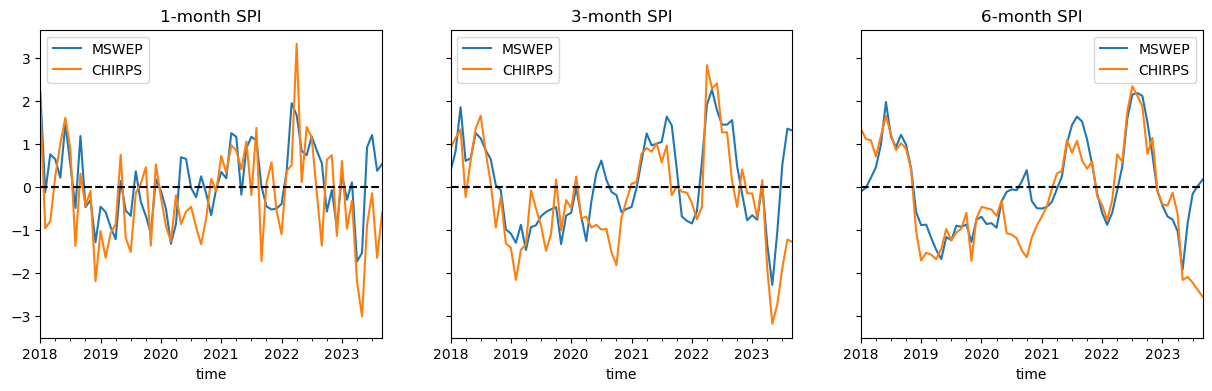

In [178]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharex = True, sharey = True) 
sl = slice("2018", None)

for i in range(3):
    nm = [1,3,6][i]
    ax = axs[i]
    mswep_spi.loc[sl]["spi_"+str(nm)].plot(ax = ax)
    chirps_spi.loc[sl]["spi_"+str(nm)].plot(ax = ax)
    # nino34rel.loc[slice("2010","2023")]["nino"+str(nm)].plot(ax = ax, color = "darkred", ls = "--", alpha = 0.5)

    ax.axhline(0, color = "k", ls = "--")
    ax.legend(["MSWEP", "CHIRPS"])
    ax.set_title(str(nm)+"-month SPI")
    
plt.savefig("fig/spi_panama_5year.png")

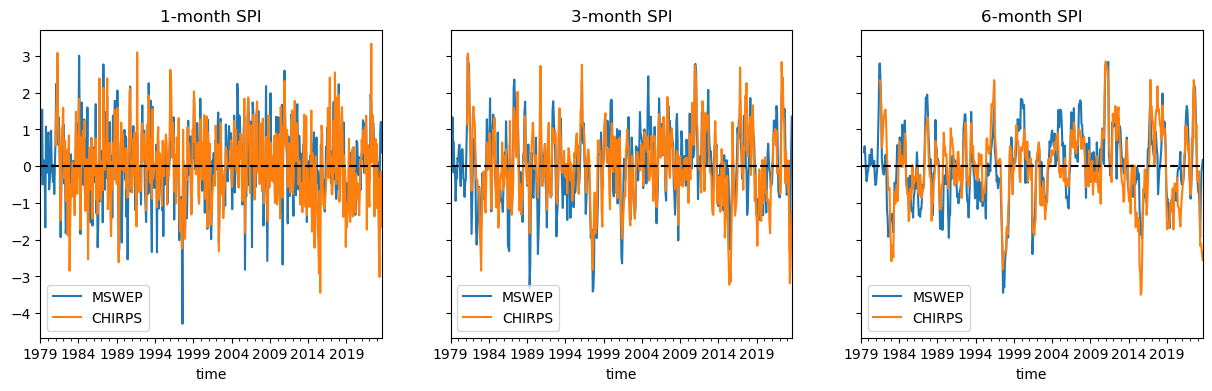

In [180]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharex = True, sharey = True) 
sl = slice(None, None)

for i in range(3):
    nm = [1,3,6][i]
    ax = axs[i]
    mswep_spi.loc[sl]["spi_"+str(nm)].plot(ax = ax)
    chirps_spi.loc[sl]["spi_"+str(nm)].plot(ax = ax)
    # nino34rel.loc[slice("2010","2023")]["nino"+str(nm)].plot(ax = ax, color = "darkred", ls = "--", alpha = 0.5)

    ax.axhline(0, color = "k", ls = "--")
    ax.legend(["MSWEP", "CHIRPS"])
    ax.set_title(str(nm)+"-month SPI")
    
plt.savefig("fig/spi_panama_trend.png")

### **Correlation between SPI & ENSO**

In [129]:
mswep_spi = pd.read_csv("data/mswep_spi-monthly.csv", index_col = "time", parse_dates = ["time"])
chirps_spi = pd.read_csv("data/chirps_spi-monthly.csv", index_col = "time", parse_dates = ["time"])

In [190]:
nino34rel = decode_times(xr.open_dataset("../../Data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].sel(time = slice("1950", "2023")).dropna("time", "any").to_dataframe()
nino34rel["nino1"] = nino34rel["Nino3.4r"].rolling(1, center = False).mean() 
nino34rel["nino3"] = nino34rel["Nino3.4r"].rolling(3, center = False).mean() 
nino34rel["nino6"] = nino34rel["Nino3.4r"].rolling(6, center = False).mean() 
nino34rel["nino12"] = nino34rel["Nino3.4r"].rolling(12, center = False).mean() 
nino34rel["nino24"] = nino34rel["Nino3.4r"].rolling(24, center = False).mean() 

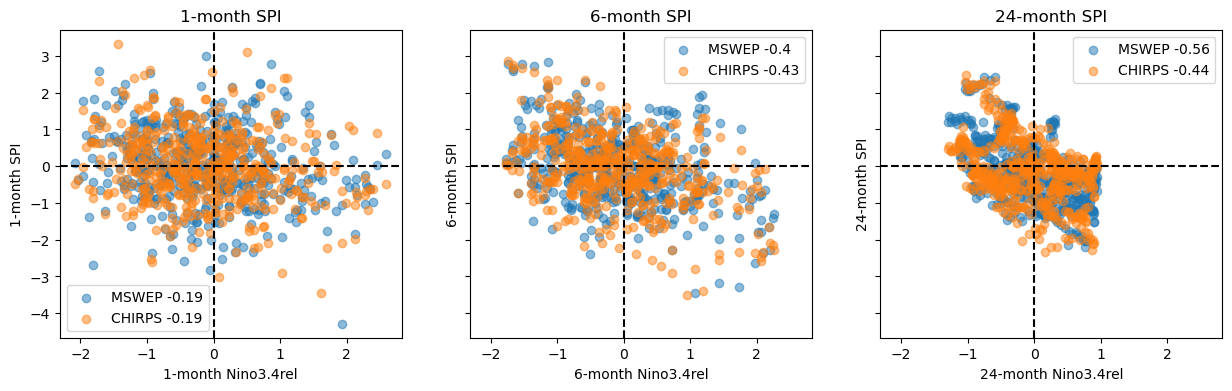

In [193]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharex = True, sharey = True) 

sl = slice("1983","2023-09")

for i in range(3):
    nm = [1,6,24][i]
    ax = axs[i]
    
    x = nino34rel.loc[sl]["nino"+str(nm)]
    y1 = mswep_spi.loc[sl]["spi_"+str(nm)]
    y2 = chirps_spi.loc[sl]["spi_"+str(nm)]
    
    ax.scatter(x, y1, alpha = 0.5)
    ax.scatter(x, y2, alpha = 0.5)

    ax.axhline(0, color = "k", ls = "--"); ax.axvline(0, color = "k", ls = "--")
    ax.legend(["MSWEP "+str(round(pearsonr(x, y1)[0], 2)),
               "CHIRPS "+str(round(pearsonr(x, y2)[0], 2))])
    
    ax.set_title(str(nm)+"-month SPI")
    ax.set_xlabel(str(nm)+"-month Nino3.4rel")
    ax.set_ylabel(str(nm)+"-month SPI")

plt.savefig("fig/spi-nino-correlatons.png")

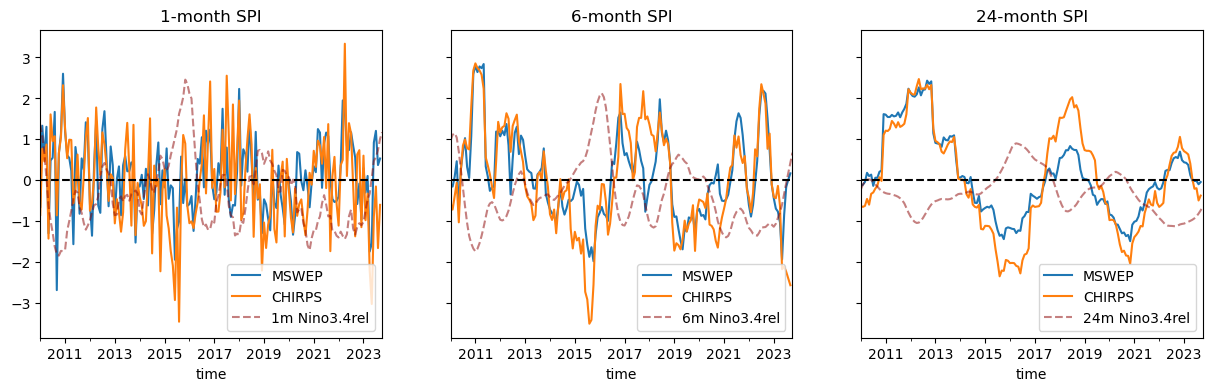

In [196]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharex = True, sharey = True) 

for i in range(3):
    nm = [1,6,24][i]
    ax = axs[i]
    mswep_spi.loc[slice("2010",None)]["spi_"+str(nm)].plot(ax = ax)
    chirps_spi.loc[slice("2010",None)]["spi_"+str(nm)].plot(ax = ax)
    nino34rel.loc[slice("2010","2023")]["nino"+str(nm)].plot(ax = ax, color = "darkred", ls = "--", alpha = 0.5)

    ax.axhline(0, color = "k", ls = "--")
    ax.legend(["MSWEP", "CHIRPS", str(nm)+"m Nino3.4rel"])
    ax.set_title(str(nm)+"-month SPI")
    
plt.savefig("fig/spi-nino_panama.png")

## **Correlation with lake levels**

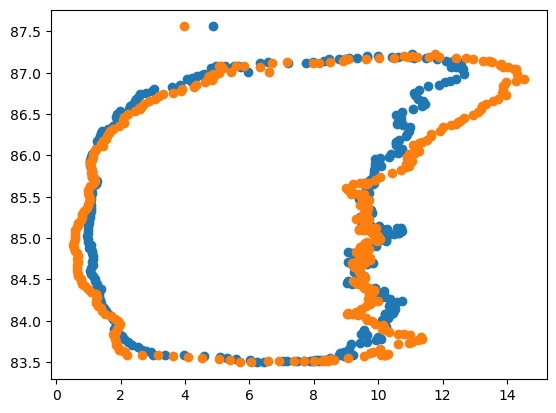

In [99]:
# not sure that this tells us much, but I like the shape
plt.scatter(mswep_clim_9020, df_clim)
plt.scatter(chirps_clim_9020, df_clim)

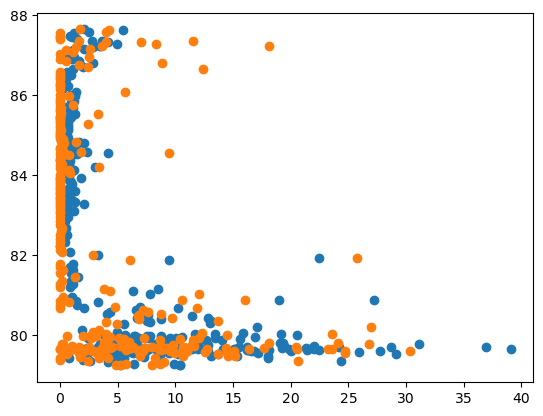

In [112]:
plt.scatter(mswep_ts.sel(time = df.loc["2023"].index), df.loc["2023"])
plt.scatter(chirps_ts.sel(time = "2023"), df.loc[chirps_ts.sel(time = "2023").time])

# **Temperature anomalies**

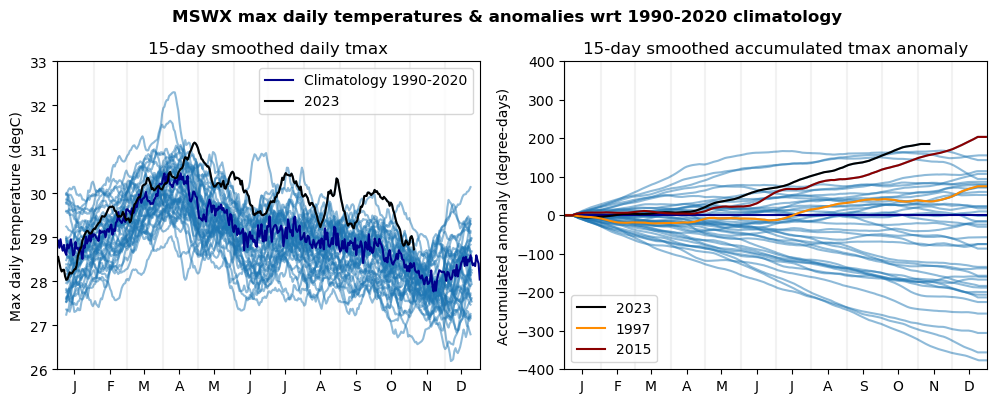

In [24]:
tmax_ts = xr.open_dataset("data/mswx-tmax_panama_ts.nc").tmax
tmax_clim_9020 = tmax_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(tmax_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(tmax_clim_9020.dayofyear, tmax_clim_9020, color = "darkblue", label = "Climatology 1990-2020")

ts_y = ts_fun(tmax_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")
ax.set_title("15-day smoothed daily tmax")
sc_xlabels(dates = tmax_ts.sel(time = "2000").time, ax = ax)

ax.legend()
ax.set_ylim(26,33)
ax.set_ylabel("Max daily temperature (degC)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - tmax_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(tmax_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkblue")
# ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred")
# ax.plot(chirps_clim_1020.dayofyear, chirps_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(tmax_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(tmax_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(tmax_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend(loc = "lower left")
ax.set_title("15-day smoothed accumulated tmax anomaly")
sc_xlabels(dates = tmax_ts.sel(time = "2000").time, ax = ax)
ax.set_ylabel("Accumulated anomaly (degree-days)")
ax.set_ylim(-400,400)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
plt.suptitle("MSWX max daily temperatures & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/mswx-tmax_anomaly-wrt-1990-2020.png")

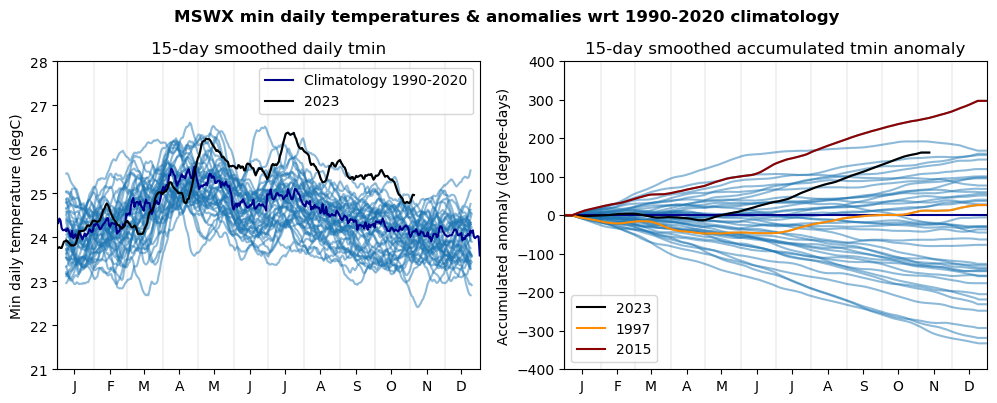

In [23]:
tmin_ts = xr.open_dataset("data/mswx-tmin_panama_ts.nc").tmin
tmin_clim_9020 = tmin_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(tmin_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(tmin_clim_9020.dayofyear, tmin_clim_9020, color = "darkblue", label = "Climatology 1990-2020")

ts_y = ts_fun(tmin_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")
ax.set_title("15-day smoothed daily tmin")
sc_xlabels(dates = tmin_ts.sel(time = "2000").time, ax = ax)

ax.legend()
ax.set_ylim(21,28)
ax.set_ylabel("Min daily temperature (degC)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - tmin_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(tmin_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkblue")
# ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred")
# ax.plot(chirps_clim_1020.dayofyear, chirps_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(tmin_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(tmin_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(tmin_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend(loc = "lower left")
ax.set_title("15-day smoothed accumulated tmin anomaly")
sc_xlabels(dates = tmin_ts.sel(time = "2000").time, ax = ax)
ax.set_ylabel("Accumulated anomaly (degree-days)")
ax.set_ylim(-400,400)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
plt.suptitle("MSWX min daily temperatures & anomalies wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)

plt.savefig("fig/mswx-tmin_anomaly-wrt-1990-2020.png")